In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### **Imports**

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

In [4]:
BATCH_SIZE = 32
NUM_ROUNDS = 20
LEARNING_RATE = 1e-3
NUM_CLIENTS = 4 # min must be 2
IMG_SIZE = (120, 120)
NUM_CLASSES = 2
rounds = 2

### **Dataset**

In [5]:
data_dir = '/content/dataset'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size= IMG_SIZE,
    batch_size= None
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size= IMG_SIZE,
    batch_size= None
)

class_names = train_dataset.class_names

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


In [6]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preparing train set
x_train = []
y_train = []
for batch in train_dataset:
    batch_images, batch_labels = batch
    x_train.append(batch_images.numpy())
    y_train.append(batch_labels.numpy())

x_train = np.concatenate([np.expand_dims(i, axis=0) for i in x_train])
y_train = np.concatenate([np.expand_dims(i, axis=0) for i in y_train])
x_train /= 255
y_train = to_categorical(y_train, len(class_names))

# Preparing validation set
x_val = []
y_val = []
for batch in val_dataset:
    batch_images, batch_labels = batch
    x_val.append(batch_images.numpy())
    y_val.append(batch_labels.numpy())

x_val = np.concatenate([np.expand_dims(i, axis=0) for i in x_val])
y_val = np.concatenate([np.expand_dims(i, axis=0) for i in y_val])
x_val /= 255
y_val = to_categorical(y_val, len(class_names))

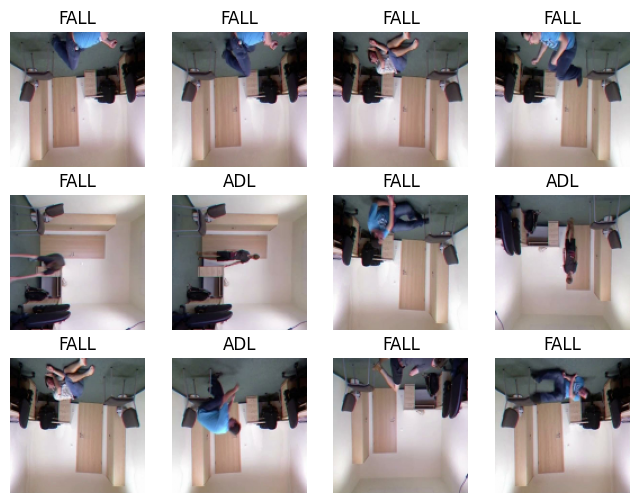

In [7]:
def visualize_dataset(x, y, class_names, num_examples=12):
    plt.figure(figsize=(8, 6))
    for i in range(num_examples):
        plt.subplot(3, 4, i + 1)
        plt.imshow(x[i])
        plt.title(class_names[y[i].argmax()])
        plt.axis('off')

visualize_dataset(x_val, y_val, class_names)
plt.show()

### **Global Model Architecture**

In [8]:
base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet"
)
base.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [9]:
def create_model(model_type="GLOBAL"):
    inputs = Input(shape=(*IMG_SIZE,3))
    base_model = base(inputs)
    x = GlobalAveragePooling2D()(base_model)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs, name="fall_detector")
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
global_model = create_model()
global_model.summary()

Model: "fall_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                     

### **Federated Training with FedAvg**

In [11]:
global_acc_list = []
global_loss_list = []

In [12]:
for epoch in range(NUM_ROUNDS):
    print(f'ROUND #{epoch+1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for i in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        client_models.append(client_model)

    # Training on local data
    for i in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{i+1}')

        # Allocating data to each clients
        start = i * (len(x_train) // NUM_CLIENTS)
        end = (i+1) * (len(x_train) // NUM_CLIENTS)
        x_train_i = x_train[start:end]
        y_train_i = y_train[start:end]
        client_models[i].fit(x_train_i, y_train_i, batch_size=BATCH_SIZE, epochs=2, verbose=0)

    # Federated Averaging
    average_weights = []
    for j in tqdm(range(len(global_model.get_weights()))):
        layer_weights = np.array([client_models[i].get_weights()[j] for i in range(NUM_CLIENTS)])
        average_layer_weights = np.mean(layer_weights, axis=0)
        average_weights.append(average_layer_weights)

    # Global Aggregation
    global_model.set_weights(average_weights)

    # Evaluate the global model
    loss, acc = global_model.evaluate(x_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    loss, acc = global_model.evaluate(x_val, y_val, verbose=0)
    global_acc_list.append(acc)
    global_loss_list.append(loss)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

ROUND #1/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.3012930452823639, Global Train Accuracy: 0.9237499833106995
Global Validation Loss: 0.30184850096702576, Global Validation Accuracy: 0.9237499833106995
_________________________________________________________
ROUND #2/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.17708374559879303, Global Train Accuracy: 0.9428125023841858
Global Validation Loss: 0.18043020367622375, Global Validation Accuracy: 0.9474999904632568
_________________________________________________________
ROUND #3/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.14445072412490845, Global Train Accuracy: 0.9518749713897705
Global Validation Loss: 0.1463884711265564, Global Validation Accuracy: 0.9449999928474426
_________________________________________________________
ROUND #4/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.1071239486336708, Global Train Accuracy: 0.9653124809265137
Global Validation Loss: 0.11123694479465485, Global Validation Accuracy: 0.9624999761581421
_________________________________________________________
ROUND #5/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.09109978377819061, Global Train Accuracy: 0.9703124761581421
Global Validation Loss: 0.09687872231006622, Global Validation Accuracy: 0.9662500023841858
_________________________________________________________
ROUND #6/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.08809539675712585, Global Train Accuracy: 0.9715625047683716
Global Validation Loss: 0.0993037298321724, Global Validation Accuracy: 0.9637500047683716
_________________________________________________________
ROUND #7/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.07398054003715515, Global Train Accuracy: 0.9740625023841858
Global Validation Loss: 0.08576131612062454, Global Validation Accuracy: 0.96875
_________________________________________________________
ROUND #8/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.06376691907644272, Global Train Accuracy: 0.9778125286102295
Global Validation Loss: 0.07290027290582657, Global Validation Accuracy: 0.9750000238418579
_________________________________________________________
ROUND #9/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.06424247473478317, Global Train Accuracy: 0.9771875143051147
Global Validation Loss: 0.07681629061698914, Global Validation Accuracy: 0.9700000286102295
_________________________________________________________
ROUND #10/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.06007392704486847, Global Train Accuracy: 0.9781249761581421
Global Validation Loss: 0.07254543155431747, Global Validation Accuracy: 0.9712499976158142
_________________________________________________________
ROUND #11/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.0529097355902195, Global Train Accuracy: 0.9818750023841858
Global Validation Loss: 0.06454569101333618, Global Validation Accuracy: 0.9750000238418579
_________________________________________________________
ROUND #12/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.050611916929483414, Global Train Accuracy: 0.9815624952316284
Global Validation Loss: 0.060663286596536636, Global Validation Accuracy: 0.9762499928474426
_________________________________________________________
ROUND #13/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.044314414262771606, Global Train Accuracy: 0.9837499856948853
Global Validation Loss: 0.05845837667584419, Global Validation Accuracy: 0.9737499952316284
_________________________________________________________
ROUND #14/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.043185729533433914, Global Train Accuracy: 0.9840624928474426
Global Validation Loss: 0.05478164181113243, Global Validation Accuracy: 0.9775000214576721
_________________________________________________________
ROUND #15/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.039035577327013016, Global Train Accuracy: 0.9837499856948853
Global Validation Loss: 0.05281924083828926, Global Validation Accuracy: 0.9775000214576721
_________________________________________________________
ROUND #16/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.03832530602812767, Global Train Accuracy: 0.9850000143051147
Global Validation Loss: 0.05273575335741043, Global Validation Accuracy: 0.9775000214576721
_________________________________________________________
ROUND #17/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.03598697856068611, Global Train Accuracy: 0.9846875071525574
Global Validation Loss: 0.04918428882956505, Global Validation Accuracy: 0.9775000214576721
_________________________________________________________
ROUND #18/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.03979382663965225, Global Train Accuracy: 0.9862499833106995
Global Validation Loss: 0.059662651270627975, Global Validation Accuracy: 0.9787499904632568
_________________________________________________________
ROUND #19/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.03151167184114456, Global Train Accuracy: 0.9871875047683716
Global Validation Loss: 0.049636319279670715, Global Validation Accuracy: 0.9750000238418579
_________________________________________________________
ROUND #20/20 


  0%|          | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


  0%|          | 0/30 [00:00<?, ?it/s]

Global Train Loss: 0.0342089980840683, Global Train Accuracy: 0.9878125190734863
Global Validation Loss: 0.045376844704151154, Global Validation Accuracy: 0.9825000166893005
_________________________________________________________


### **Evaluation**

In [13]:
train_loss, train_acc = global_model.evaluate(x_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")

100/100 [==============================] - 4s 41ms/step - loss: 0.0342 - accuracy: 0.9878
Train Accuracy : 0.9878125190734863
Train Loss : 0.0342089980840683


In [14]:
val_loss, val_acc = global_model.evaluate(x_val, y_val)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")

25/25 [==============================] - 1s 41ms/step - loss: 0.0454 - accuracy: 0.9825
Validation Accuracy : 0.9825000166893005
Validation Loss : 0.045376844704151154


In [15]:
from sklearn.metrics import classification_report
predictions = global_model.predict(x_val)
predicted_labels = tf.argmax(predictions, axis=1)

true_labels = tf.argmax(y_val, axis=1)

class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

25/25 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0   0.986911  0.976684  0.981771       386
           1   0.978469  0.987923  0.983173       414

    accuracy                       0.982500       800
   macro avg   0.982690  0.982303  0.982472       800
weighted avg   0.982542  0.982500  0.982496       800



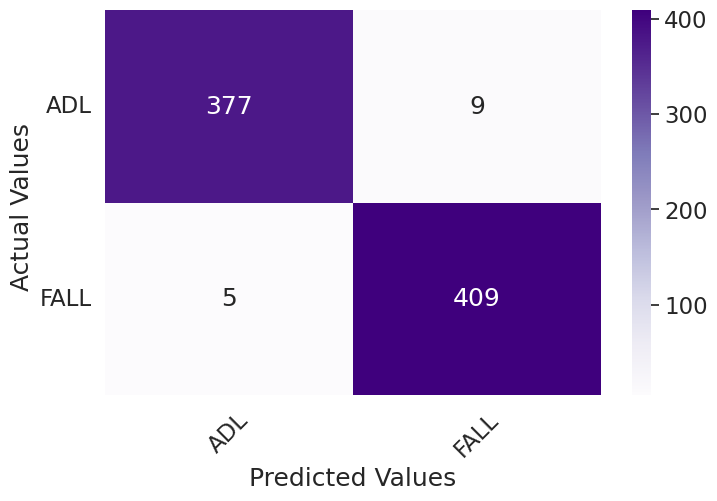

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, xticklabels=class_names, yticklabels=class_names)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

Text(0.5, 1.0, 'Global Acc')

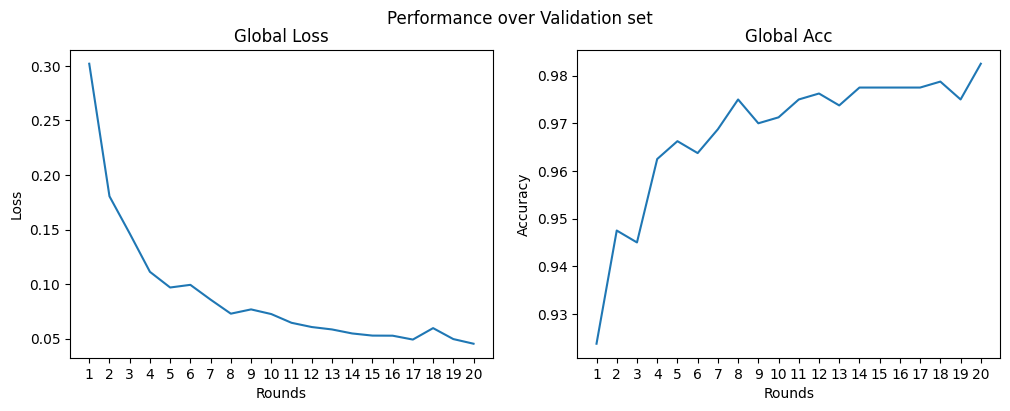

In [27]:
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.suptitle("Performance over Validation set")

plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list)+1), global_loss_list)
plt.xticks(range(1, len(global_loss_list)+1))
plt.title("Global Loss")

plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_acc_list)+1), global_acc_list)
plt.xticks(range(1, len(global_acc_list)+1))
plt.title("Global Acc")